In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy.linalg import solve, inv
from sympy import DiracDelta, lambdify
import sympy as sp
import sys

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

$$Ω\propto r^{-3/2}$$

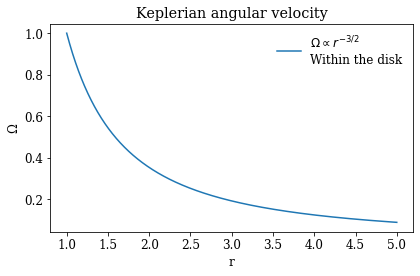

In [11]:
r = np.linspace(1, 5, 1000)

fig, axs = plt.subplots(figsize = (6,4))
axs.set(title='Keplerian angular velocity', xlabel='r', ylabel='Ω')
axs.plot(r, r**(-3/2), label='$Ω\propto r^{-3/2}$\nWithin the disk')

axs.legend(frameon = False)
plt.tight_layout()

$$\frac{\partial\Sigma}{\partial t}  
= \frac{3}{r} \frac{\partial}{\partial r}
\left[r^{1/2} \frac{\partial}{\partial r}(\nu\Sigma r^{1/2})\right] 
$$
$$X \equiv 2r^{1/2}, \quad f \equiv \frac{3}{2}\Sigma X$$

$$\Rightarrow \frac{\partial f}{\partial t}=\frac{12\nu}{X^2}\frac{\partial^2f}{\partial X^2}$$

### *Initial condition for Green's solution*
$$\Sigma(r,t=0)=\frac{m}{2\pi r_0}\delta(r-r_0)$$

In [12]:
N = 1001
x_i = 0
x_f = 2
x = np.linspace(x_i, x_f, N)
Δx = x[1] - x[0]
Δt = 0.004/12

D = A_matrix(4, 2, N) / Δx**2

In [13]:
x

array([0.   , 0.002, 0.004, ..., 1.996, 1.998, 2.   ])

In [14]:
A = np.identity(N) - D * Δt


A[0] = 0
A[0, :5] = forward_backward(5, 1, forward = True)[0]
A[-1] = 0
A[-1, -5:] = forward_backward(5, 1, forward = False)[0]

In [21]:
A_ = inv(A)

t = np.arange(0, 0.256 + Δt, Δt)
sol = []
b = np.zeros_like(x)
b[x == 1] = 5
b_initial = b.copy()
for _ in t:
    b[0] = 0
    b[-1] = 0
    sol.append(A_ @ b)
    b = A_ @ b 
sol = np.asarray(sol)

In [22]:
b_initial

array([0., 0., 0., ..., 0., 0., 0.])

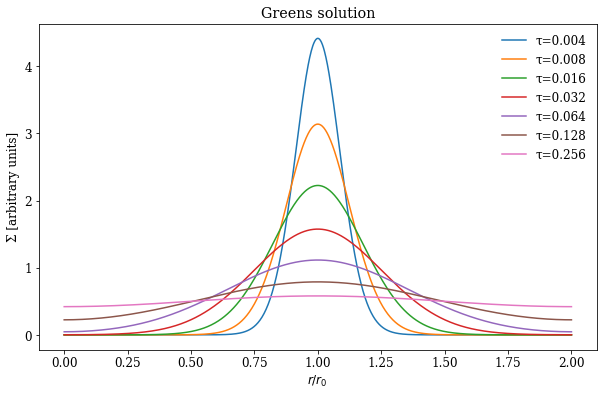

In [25]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in [0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]:
    axs.plot(x, 100*sol[t == τ][0], label=f'τ={τ}')
#for i in range(0, 10):
#    axs.plot(x, sol[i], label=f'τ={t[i]:1.2e}')

#axs.plot(x, b_initial, label='Initial condition')
axs.set(title='Greens solution', ylabel='Σ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False)